In [7]:
#imports
import numpy as np
import numpy.linalg as npl
import numpy.random as npr

import scipy as sp
import scipy.linalg as spl
import scipy.stats as sps

import pandas as pd

import matplotlib.pyplot as plt

In [40]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from our_package import * #allows us to use our functions directly

In [9]:
### we call the different functions
T = 5
Lambda = 1

D = BuildD(T)
U, Delta, Vt = BuildUVDelta(D)
A = BuildA(Delta, Vt)
sh = Buildsh(T, a, b)
Y = Computation_Y(T, Lambda)
x,x_tilde = ComputeArgmax(T,Lambda, Y)
mu,mu_tilde = ComputeMeans(T,Lambda, Y)
q1 = ComputeQuantiles(T,Lambda,0.975*np.ones(T), Y)
q2 = ComputeQuantiles(T,Lambda,0.025*np.ones(T), Y)
med = ComputeQuantiles(T,Lambda,0.5*np.ones(T), Y)
sim_theta,sim_theta_tilde,sim_accepts,sim_gammas, Mean = MetropolisHastings(T,Lambda, Y, 1e5, "image")
#Mean=np.sum(sim_theta,axis=0)/sim_theta.shape[0]
q = np.array([2.5,50,97.5])
quantiles_emp = Quantiles(sim_theta_tilde, q,T)

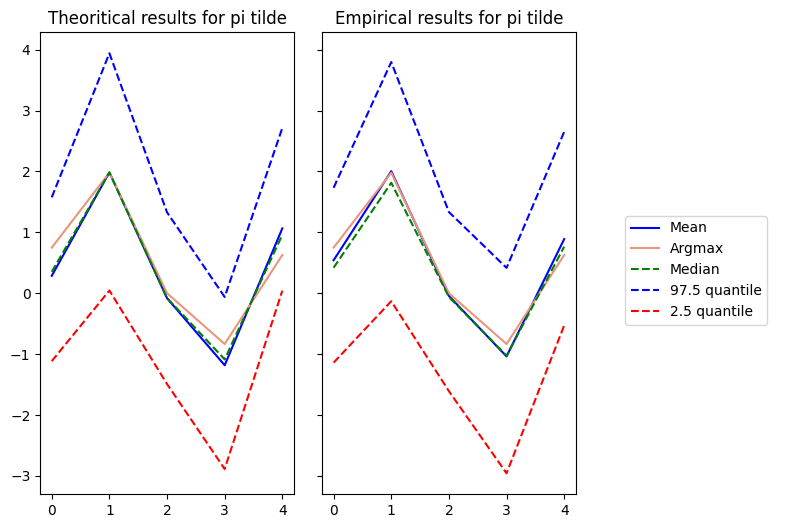

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 6), sharey=True)
#Plot of theoritical results
axes[0].plot(mu_tilde,color="blue",label="Mean")
axes[0].plot(x_tilde,color="darksalmon",label="Argmax")
axes[0].plot(med,'g--',label="Median")
axes[0].plot(q1,'b--',label="97.5 quantile")
axes[0].plot(q2,'r--',label="2.5 quantile")
axes[0].set_title("Theoritical results for pi tilde")


#Plot of empirical results
axes[1].plot(D@Mean,color="blue")
axes[1].plot(x_tilde,color="darksalmon")
axes[1].plot(quantiles_emp[1],'g--')
axes[1].plot(quantiles_emp[2],'b--')
axes[1].plot(quantiles_emp[0],'r--')
axes[1].set_title("Empirical results for pi tilde")

# Shrink current axis by 20%
box0,box1 = axes[0].get_position(),axes[1].get_position()
axes[0].set_position([box0.x0, box0.y0, box0.width * 0.8, box0.height])
axes[1].set_position([box1.x0*0.8, box1.y0, box1.width * 0.8, box1.height])
fig.legend(loc=(0.8*box1.x0+box1.width,box1.height/2))
plt.show()

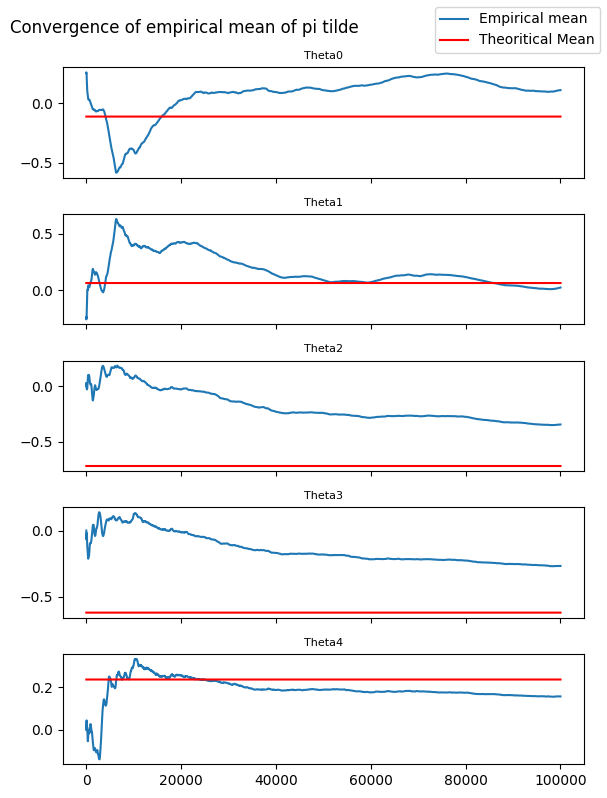

In [13]:
#Convergence plot of the mean of theta_tilde
nb_iter=sim_theta.shape[0]
x=np.linspace(1,nb_iter,nb_iter)
mean_tab=np.cumsum(sim_theta_tilde,axis=0)

fig,Axes = plt.subplots(T,1,figsize=(6,8),sharex=True)
for i in range(T):
    ax = Axes[i]
    res=mean_tab[:,i]/x
    ax.plot(x,res,label="Empirical mean" if i==0 else "")
    ax.plot(x,mu_tilde[i]*np.ones(nb_iter),'r',label="Theoretical Mean" if i==0 else "")
    ax.set_title(f"Theta{i}",fontsize=8)

fig.suptitle("Convergence of empirical mean of pi tilde", x=0.3)
fig.tight_layout()
fig.legend()
plt.show()

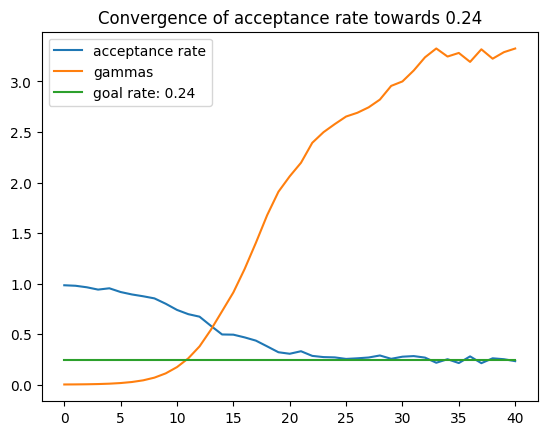

In [11]:
plt.plot(sim_accepts,label="acceptance rate")
plt.plot(sim_gammas[:-1],label="gammas")
plt.plot(np.ones(len(sim_accepts))*0.24,label="goal rate: 0.24")
plt.title("Convergence of acceptance rate towards 0.24")
plt.legend()
plt.show()

In this part of the notebook, we will estimate $\theta$ under different $\lambda \in \Lambda$. We define a list containing different $\lambda$ and we will create a DataFrame that computes the relative error for every component of $\theta$ 10 times, and we will look at the mean and standard deviation of the relative error for every component.

In [12]:
Lambdas = [0.1] + [0.5*i for i in range(1,10)] + [7.5,10]#np.arange(0.5,5,0.5)#[0.1,0.5,0.8,1,1.3,1.6,2,4,7,9]
T = 5
niter = 1e5
nb_sim = 10
method = "source"
n = len(Lambdas)
sim_theta_tildes = np.zeros((T,10,n))
npr.seed(42)

for k in range(n):
    for j in range(nb_sim):
        Y = Computation_Y(T, Lambdas[k])
        _, sim_theta_tildes[:,j,k] = MetropolisHastingsFast(T, Lambdas[k], Y,niter=niter,method=method)
        print("working...")
    print(f"Oooh yeah! Finished {k}. iteration")

working...
working...


KeyboardInterrupt: 

In [223]:
print(pd.DataFrame(sim_theta_tildes[:,:,-1]))

          0         1          2         3         4         5         6  \
0  0.990508  0.718772   0.818914  0.794490  4.387645  7.558591  0.651100   
1 -0.872940 -0.980379  -0.929508 -0.845305 -0.988176  4.406351 -0.949942   
2  0.292853 -0.019557   0.027067  0.033720  0.113127 -0.016718  0.003481   
3 -0.021516  0.021020  16.651959  0.162024 -0.036494  0.135481 -0.017328   
4 -0.013966 -0.021289   0.096194  0.017341 -0.011614  4.471916  0.022063   

          7          8         9  
0  0.749045   0.138368  0.769977  
1 -0.949000  10.879482 -0.906943  
2  0.033418  -0.112516  0.050195  
3  0.005836  -0.076382  0.019306  
4  0.016880  -0.025887 -0.002058  


The simulated $\theta$ sometimes takes tiny values close to 0, although the theoretical value is a bigger real number. This means that the relative error can exaggerate the magnitude of the error, since we divide by a small number. Therefore we opt for the following error:
$d(x,y) = \frac{|x-y|}{max(|x|,|y|}$

In [14]:
def dist(x,y):
    return np.abs(x-y)/np.maximum(np.abs(x),np.abs(y))

In [161]:
a = np.array([1,2,3,4])
b = np.array([3,4,8,9])
dist(a,b)

array([0.66666667, 0.5       , 0.625     , 0.55555556])

In [189]:
np.shape(errors)

(5, 10, 12)

In [190]:
errors = np.zeros(np.shape(sim_theta_tildes))
npr.seed(42)
for k in range(n):
    Y = Computation_Y(T, Lambdas[k])
    _, theoretical_means = ComputeMeans(T, Lambdas[k], Y)
    errors[:,:,k] = dist(sim_theta_tildes[:,:,k],theoretical_means[:,np.newaxis] @ np.ones((1,nb_sim)))
    #errors[:,:,k] = abs(sim_theta_tildes[:,:,k] - theoretical_means[:,np.newaxis] @ np.ones((1,10))) / np.max(np.abs(sim_theta_tildes[:,:,k])

In [193]:
print(np.shape(errors))
data = np.zeros((T,2*n))
for i in range(n//2+1):
    data[:,2*i] = np.mean(errors[:,:,i],axis=1)
    data[:,2*i+1]=np.std(errors[:,:,i],axis=1)
assert np.shape(data)==(T,2*n)
df = pd.DataFrame(data)

df.columns = pd.MultiIndex.from_product([Lambdas,["mean","std"]],names=["lambdas","measure"])

(5, 10, 12)


In [225]:
errors[:,:,-1]

array([[0.66685202, 0.75824791, 0.7245659 , 0.73278078, 0.32237513,
        0.60664931, 0.78100854, 0.74806594, 0.95346127, 0.74102563],
       [0.01103505, 0.09965413, 0.05037908, 0.04234225, 0.10675815,
        1.20031997, 0.07080644, 0.06988409, 1.08113254, 0.02675234],
       [0.96933585, 1.00204779, 0.99716585, 0.99646919, 0.9881547 ,
        1.00175046, 0.99963552, 0.99650083, 1.01178138, 0.99474417],
       [1.00216929, 0.99788075, 0.40435941, 0.98366456, 1.00367936,
        0.98634064, 1.00174698, 0.99941161, 1.00770086, 0.99805352],
       [1.0013979 , 1.00213097, 0.99037131, 0.99826423, 1.00116248,
        0.55237761, 0.99779153, 0.99831038, 1.00259118, 1.00020603]])

In [203]:
df_mean = df.mean()

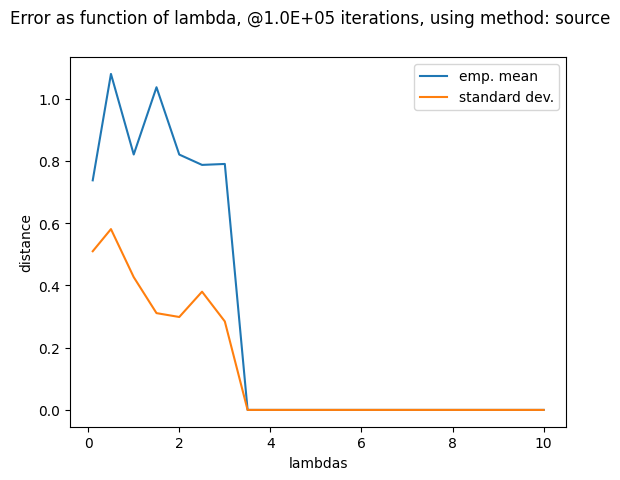

In [222]:
fig,ax = plt.subplots(1,1)
df_mean.xs("mean", level=1, axis=0).plot(label="emp. mean")
df_mean.xs("std",  level=1, axis=0).plot(label="standard dev.")
fig.suptitle(f"Error as function of lambda, @{niter:.1E} iterations, using method: {method}")
ax.set_ylabel("distance")
ax.legend()
plt.show()

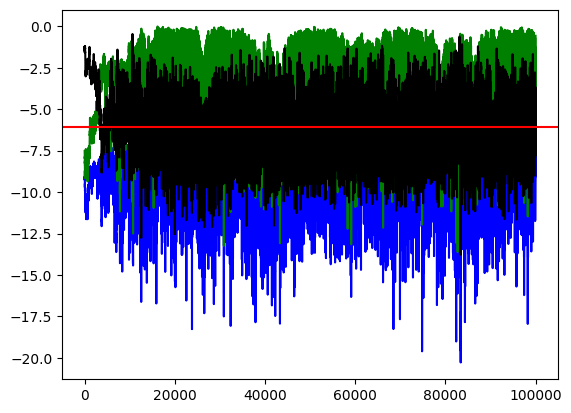

In [41]:
plt.figure()
#print(sim_theta)
#print(LogDistributionPi_Tab(sim_theta, Y, A, D, sh, Lambda))
T = 5
Lambda = 1
Y = Computation_Y(T, Lambda)
theta_tab, theta_tilde_tab, accepts, gammas, theta_mean, L1_tab, L2_tab = MetropolisHastingsFull(T, Lambda, Y)
plt.plot(LogDistributionPi_Tab(theta_tab, Y, A, D, sh, Lambda), color = "blue")
plt.plot(L1_tab, color = "green")
plt.plot(L2_tab, color = "black")
plt.axhline(LogDistributionPi(ComputeArgmax(T, Lambda, Y)[0], Y, A, D, sh, Lambda), color = "red")
plt.show()